# Orlen fuel prices analysis
Projekt ma na celu porównanie hurtowych cen paliw oferowanych w Polsce z cenami zakupu ropy brent oraz kursem USD/PLN. Ma to na celu określenie zmian cen paliw na rynku Polskim w odniesieniu do zmian gospodarczych, a także stwierdzeniu czy występują okresy, w których ceny paliw nie korelowały z innymi czynnikami na nie wpływającymi.

In [33]:
import pandas as pd 
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from datetime import datetime, timedelta
import numpy as np

load_dotenv()

True

## 1. Wczytywanie danych

In [3]:
# Pobranie danych historycznych dotyczących cen ropy brent z pliku csv
brent = pd.read_csv('Brent od 01-01-2014.csv')  
brent

,Data,Ostatnio,Otwarcie,Max.,Min.,Wol.,Zmiana%
0,17.01.2024,"78,03","77,78","78,14","76,52",NaN,"-0,33%"
1,16.01.2024,"78,29","78,43","79,40","77,60","298,55K","0,18%"
2,15.01.2024,"78,15","78,14","78,90","76,85","177,69K","-0,18%"
3,12.01.2024,"78,29","78,75","80,75","77,96","401,34K","1,14%"
4,11.01.2024,"77,41","76,70","79,10","76,66","396,77K","0,79%"
...,...,...,...,...,...,...,...
2589,07.01.2014,"107,35","107,03","107,72","106,88","188,20K","0,58%"
2590,06.01.2014,"106,73","106,80","107,96","106,58","181,82K","-0,15%"
2591,03.01.2014,"106,89","107,88","108,64","106,79","191,13K","-0,83%"
2592,02.01.2014,"107,78","111,00","111,35","107,65","200,65K","-2,83%"


In [4]:
# Pobranie danych histyorycznych kursu USD z pliku CSV
USD = pd.read_csv('USD_01-01-2014-2024.csv')
USD

,Tabela,Data,Kurs średni,Zmiana
0,12/A/NBP/2024,2024-01-17,4.0434,0.19
1,11/A/NBP/2024,2024-01-16,4.0358,0.99
2,10/A/NBP/2024,2024-01-15,3.9963,0.55
3,9/A/NBP/2024,2024-01-12,3.9746,0.17
4,8/A/NBP/2024,2024-01-11,3.9680,0.06
...,...,...,...,...
2529,5/A/NBP/2014,2014-01-09,3.0695,-0.07
2530,4/A/NBP/2014,2014-01-08,3.0717,0.09
2531,3/A/NBP/2014,2014-01-07,3.0688,0.56
2532,2/A/NBP/2014,2014-01-03,3.0517,0.67


In [5]:
# Pobranie danych dotyczących cen hurtowych cen ON ze strony internetowej lotos.pl
# Adres URL strony z cenami paliw
url = 'https://www.lotos.pl/145/type,oil_eurodiesel/dla_biznesu/hurtowe_ceny_paliw/archiwum_cen_paliw'

# Ustawienie zakresu dat
start_date = datetime(2014, 1, 1)
end_date = datetime(2023, 12, 31)

# Funkcja do pobrania i przetworzenia danych
def scrape_fuel_prices(url, start_date, end_date):
    # Tutaj będziemy przechowywać zebrane dane
    data = []

    # Pobranie zawartości strony
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Znalezienie tabeli z danymi
    table = soup.find('table')
    rows = table.find_all('tr')[1:]  # Pomijamy nagłówek tabeli

    for row in rows:
        cols = row.find_all('td')
        date_str = cols[0].text.strip()
        price = cols[1].text.strip()  # Dostosuj indeks kolumny do potrzeb

        # Konwersja daty na obiekt datetime
        date = datetime.strptime(date_str, '%Y-%m-%d')

        # Sprawdzenie, czy data mieści się w podanym zakresie
        if start_date <= date <= end_date:
            data.append({'date': date, 'price': price})

    df = pd.DataFrame(data)
    return df

# Wywołanie funkcji i wyświetlenie wyników
diesel_prices = scrape_fuel_prices(url, start_date, end_date)

In [6]:
diesel_prices

,date,price
0,2023-12-30,"4 965,00"
1,2023-12-29,"5 009,00"
2,2023-12-28,"5 049,00"
3,2023-12-23,"5 082,00"
4,2023-12-22,"5 090,00"
...,...,...
2504,2014-01-08,"4 146,00"
2505,2014-01-04,"4 143,00"
2506,2014-01-03,"4 160,00"
2507,2014-01-02,"4 196,00"


## 2. Ujednolicenie danych

In [7]:
# Ujednolicenie formatu daty zebranych danych
brent['Data'] = pd.to_datetime(brent["Data"])
USD['Data'] = pd.to_datetime(USD["Data"])
diesel_prices['Data'] = pd.to_datetime(diesel_prices["date"])

C:\Users\MariuszKamiński\AppData\Local\Temp\ipykernel_16408\3129396474.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  brent['Data'] = pd.to_datetime(brent["Data"])


In [8]:
# Połączenie dataFrame'ów
merged_df = pd.merge(brent, USD, on='Data', how='inner')
merged_df = pd.merge(merged_df, diesel_prices, left_on='Data', right_on='Data', how='inner')
merged_df.head()

,Data,Ostatnio,Otwarcie,Max.,Min.,Wol.,Zmiana%,Tabela,Kurs średni,Zmiana,date,price
0,2023-12-29,"77,04","77,38","77,98","76,73","192,95K","-1,72%",251/A/NBP/2023,3.9350,0.92,2023-12-29,"5 009,00"
1,2023-12-28,"78,39","79,80","79,95","78,25","18,78K","-1,58%",250/A/NBP/2023,3.8990,-0.48,2023-12-28,"5 049,00"
2,2023-12-22,"79,07","79,35","80,37","78,88","119,19K","-0,40%",248/A/NBP/2023,3.9338,-0.77,2023-12-22,"5 090,00"
3,2023-12-21,"79,39","79,00","80,13","77,81","193,32K","-0,39%",247/A/NBP/2023,3.9645,0.30,2023-12-21,"5 082,00"
4,2023-12-20,"79,70","79,17","80,60","79,07","241,81K","0,59%",246/A/NBP/2023,3.9527,-0.16,2023-12-20,"5 039,00"


In [9]:
# Usunięcie zbędnych kolumn
merged_df = merged_df.drop(columns=['Otwarcie', 'Max.', 'Min.', 'Wol.', 'Zmiana%', 'Tabela', 'Zmiana', 'date'])
merged_df.head()

,Data,Ostatnio,Kurs średni,price
0,2023-12-29,"77,04",3.9350,"5 009,00"
1,2023-12-28,"78,39",3.8990,"5 049,00"
2,2023-12-22,"79,07",3.9338,"5 090,00"
3,2023-12-21,"79,39",3.9645,"5 082,00"
4,2023-12-20,"79,70",3.9527,"5 039,00"


In [10]:
# Zmiana nazw kolumn
merged_df = merged_df.rename(columns={'Ostatnio': 'Brent USD/b',
                                      'Kurs średni': 'PLN/USD',
                                      'price': 'Eurodiesel'})
merged_df.set_index('Data', inplace=True)
merged_df.head()
merged_df.dtypes

Brent USD/b     object
PLN/USD        float64
Eurodiesel      object
dtype: object

In [11]:
# Zmiana separatorów dziesiętnych z ',' na '.', zmiana typu danych z int na float, usunięcie białych spacji
merged_df['Brent USD/b'] = merged_df['Brent USD/b'].str.replace(',', '.').str.replace(' ', '').astype(float)
merged_df['Eurodiesel'] = merged_df['Eurodiesel'].str.replace(',', '.').str.replace(' ', '').astype(float)
merged_df.dtypes

Brent USD/b    float64
PLN/USD        float64
Eurodiesel     float64
dtype: object

In [12]:
are_any_cells_empty = merged_df.isna().any().any()
print("Czy są jakieś puste komórki w DataFrame:", are_any_cells_empty)


Czy są jakieś puste komórki w DataFrame: False


In [13]:
merged_df

,Brent USD/b,PLN/USD,Eurodiesel
Data,,,
2023-12-29,77.04,3.9350,5009.0
2023-12-28,78.39,3.8990,5049.0
2023-12-22,79.07,3.9338,5090.0
2023-12-21,79.39,3.9645,5082.0
2023-12-20,79.70,3.9527,5039.0
...,...,...,...
2014-01-10,107.25,3.0700,4136.0
2014-01-09,106.39,3.0695,4150.0
2014-01-08,107.15,3.0717,4146.0


## 3. Analiza danych

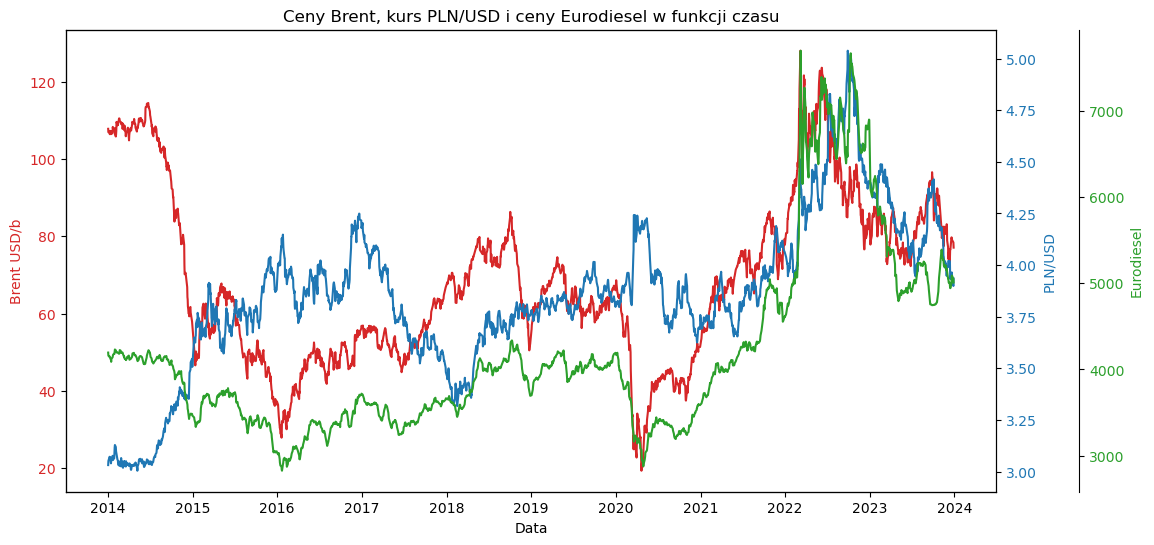

In [14]:
# Tworzenie zbiorczego wykresu danych
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent USD/b', color=color)
ax1.plot(merged_df['Brent USD/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('PLN/USD', color=color)  
ax2.plot(merged_df['PLN/USD'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))      
ax3.set_ylabel('Eurodiesel', color=color)
ax3.plot(merged_df['Eurodiesel'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent, kurs PLN/USD i ceny Eurodiesel w funkcji czasu')

plt.show()

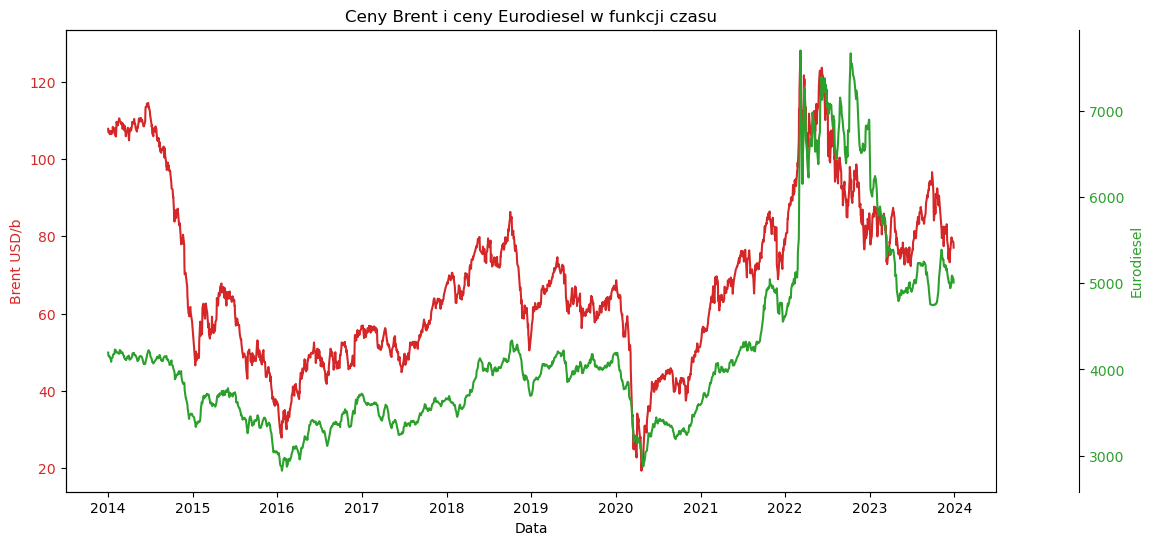

In [15]:
# Tworzenie zbiorczego wykresu danych
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent USD/b', color=color)
ax1.plot(merged_df['Brent USD/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 60))      
ax2.set_ylabel('Eurodiesel', color=color)
ax2.plot(merged_df['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent i ceny Eurodiesel w funkcji czasu')

plt.show()

In [16]:
# Analiza korealcji pomiędzy poszczególnymi seriami danych w całym badanym okresie
macierz_korelacji = merged_df.corr()
macierz_korelacji

,Brent USD/b,PLN/USD,Eurodiesel
Brent USD/b,1.000000,-0.035190,0.742698
PLN/USD,-0.035190,1.000000,0.588833
Eurodiesel,0.742698,0.588833,1.000000


In [17]:
# Przeliczenie cen baryłki ropy Brent na PLN
brent_PLN = merged_df.copy()
brent_PLN['Brent PLN/b'] = brent_PLN['Brent USD/b'] * brent_PLN['PLN/USD']
brent_PLN

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400
2023-12-28,78.39,3.8990,5049.0,305.642610
2023-12-22,79.07,3.9338,5090.0,311.045566
2023-12-21,79.39,3.9645,5082.0,314.741655
2023-12-20,79.70,3.9527,5039.0,315.030190
...,...,...,...,...
2014-01-10,107.25,3.0700,4136.0,329.257500
2014-01-09,106.39,3.0695,4150.0,326.564105
2014-01-08,107.15,3.0717,4146.0,329.132655


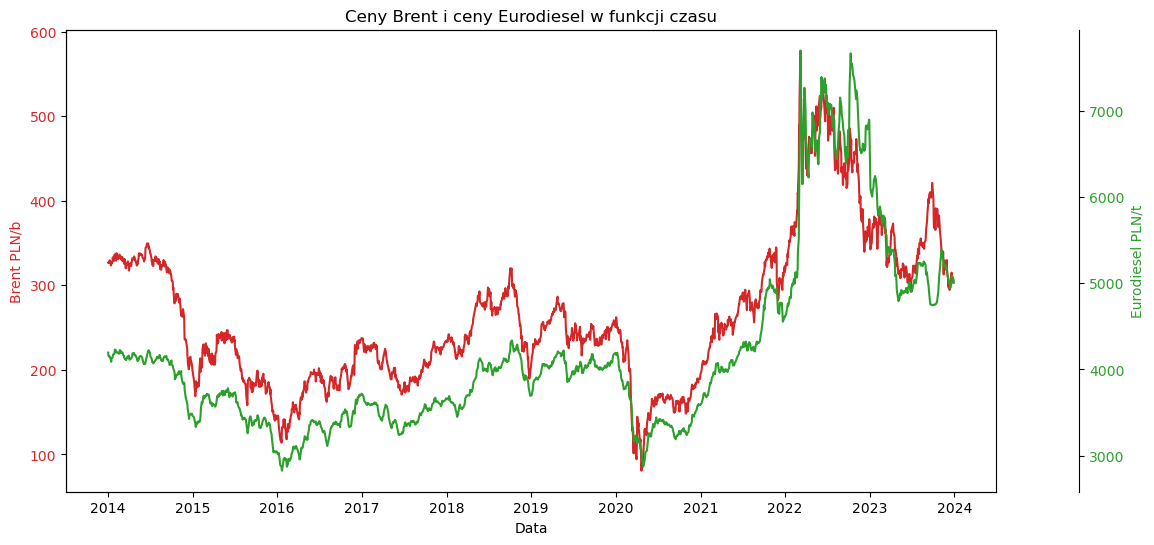

In [18]:
# Tworzenie zbiorczego wykresu danych
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent PLN/b', color=color)
ax1.plot(brent_PLN['Brent PLN/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 60))      
ax2.set_ylabel('Eurodiesel PLN/t', color=color)
ax2.plot(brent_PLN['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent i ceny Eurodiesel w funkcji czasu')

plt.show()

In [19]:
# Analiza korealcji pomiędzy poszczególnymi seriami danych w całym badanym okresie
macierz_korelacji_2 = brent_PLN.corr()
macierz_korelacji_2

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Brent USD/b,1.000000,-0.035190,0.742698,0.920090
PLN/USD,-0.035190,1.000000,0.588833,0.350902
Eurodiesel,0.742698,0.588833,1.000000,0.927633
Brent PLN/b,0.920090,0.350902,0.927633,1.000000


In [20]:
brent_PLN.head()

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400
2023-12-28,78.39,3.8990,5049.0,305.642610
2023-12-22,79.07,3.9338,5090.0,311.045566
2023-12-21,79.39,3.9645,5082.0,314.741655
2023-12-20,79.70,3.9527,5039.0,315.030190


## 4. Opracowanie modelu do przewidywania cen Eurodiesel w oparciu o kurs ropy brent w PLN

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
base_brent_PLN = brent_PLN[:'2021-12-31'].copy()
base_brent_PLN

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2021-12-31,77.78,4.0600,4611.0,315.786800
2021-12-30,79.32,4.0631,4618.0,322.285092
2021-12-24,76.14,4.0785,4565.0,310.536990
2021-12-23,76.85,4.0950,4561.0,314.700750
2021-12-22,75.29,4.0984,4554.0,308.568536
...,...,...,...,...
2014-01-10,107.25,3.0700,4136.0,329.257500
2014-01-09,106.39,3.0695,4150.0,326.564105
2014-01-08,107.15,3.0717,4146.0,329.132655


In [23]:
# Podział danych na zmienne niezależne 'X' i zależną 'y'
X = base_brent_PLN[['Brent PLN/b']]  # Zmienne niezależne
y = base_brent_PLN['Eurodiesel']  # Zmienna zależna


In [24]:
# Podział danych na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Budowa modelu regresji liniowej
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [26]:
# Przewidywanie na zestawie testowym
y_pred = model.predict(X_test)

In [27]:
# Ocena modelu
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 30941.32210848293
R2 Score: 0.8273826410636077


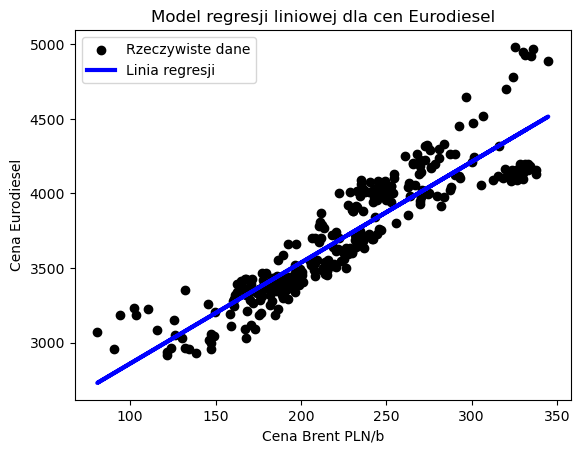

In [28]:
import matplotlib.pyplot as plt

# Wykres rozproszenia danych testowych
plt.scatter(X_test, y_test, color='black', label='Rzeczywiste dane')

# Linia regresji
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Linia regresji')

# Dodanie tytułu wykresu i etykiet osi
plt.title('Model regresji liniowej dla cen Eurodiesel')
plt.xlabel('Cena Brent PLN/b')
plt.ylabel('Cena Eurodiesel')

# Wyświetlenie legendy
plt.legend()

# Pokazanie wykresu
plt.show()


In [29]:
brent_PLN_2022 = brent_PLN['2022-01-05':].copy()
brent_PLN_2022

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400
2023-12-28,78.39,3.8990,5049.0,305.642610
2023-12-22,79.07,3.9338,5090.0,311.045566
2023-12-21,79.39,3.9645,5082.0,314.741655
2023-12-20,79.70,3.9527,5039.0,315.030190
...,...,...,...,...
2022-01-13,84.47,3.9463,4767.0,333.343961
2022-01-12,84.67,3.9879,4755.0,337.655493
2022-01-11,83.72,4.0106,4735.0,335.767432


In [30]:
# Ocena działania modelu na danych od roku 2022
X_predict = brent_PLN_2022[['Brent PLN/b']]  # Zmienne niezależne
predicted_eurodiesel_prices = model.predict(X_predict)
brent_PLN_2022['Predicted Eurodiesel Price'] = predicted_eurodiesel_prices
brent_PLN_2022

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b,Predicted Eurodiesel Price
Data,,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400,4233.204118
2023-12-28,78.39,3.8990,5049.0,305.642610,4250.041084
2023-12-22,79.07,3.9338,5090.0,311.045566,4286.571892
2023-12-21,79.39,3.9645,5082.0,314.741655,4311.562123
2023-12-20,79.70,3.9527,5039.0,315.030190,4313.512984
...,...,...,...,...,...
2022-01-13,84.47,3.9463,4767.0,333.343961,4437.337211
2022-01-12,84.67,3.9879,4755.0,337.655493,4466.488614
2022-01-11,83.72,4.0106,4735.0,335.767432,4453.722937


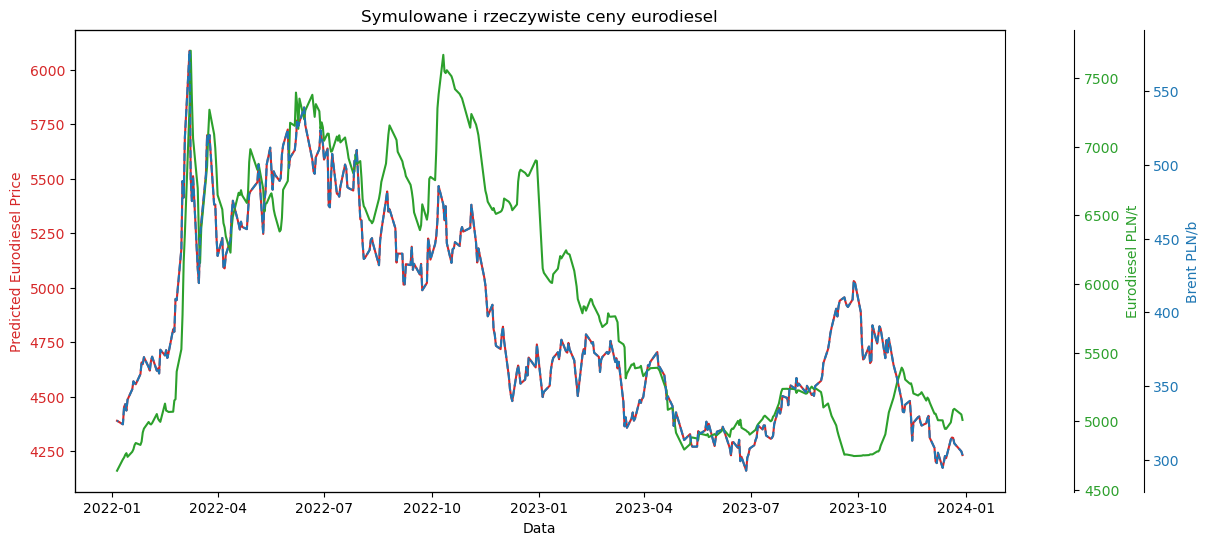

In [31]:
# Tworzenie porównawczego wykresu danych modelowych i rzeczywistych
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Predicted Eurodiesel Price', color=color)
ax1.plot(brent_PLN_2022['Predicted Eurodiesel Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 50))      
ax2.set_ylabel('Eurodiesel PLN/t', color=color)
ax2.plot(brent_PLN_2022['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
ax3.set_xlabel('Data')
color = 'tab:blue'
ax3.spines['right'].set_position(('outward', 100))
ax3.set_ylabel('Brent PLN/b', color=color)
ax3.plot(brent_PLN_2022['Brent PLN/b'], color=color, linestyle='--')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Symulowane i rzeczywiste ceny eurodiesel')

plt.show()

Analiza powyższego wykresu wskazuje, że w okresie 11.2022-01.2023 oraz 09.2023-11.2023 ceny paliwa Eurodiesel znacząco odbiegają od cen ropy brent oraz wartości modelowych. Mogłoby to wskazywać na pozarynkowe przyczyny poziomu cen.

<Axes: xlabel='Data'>

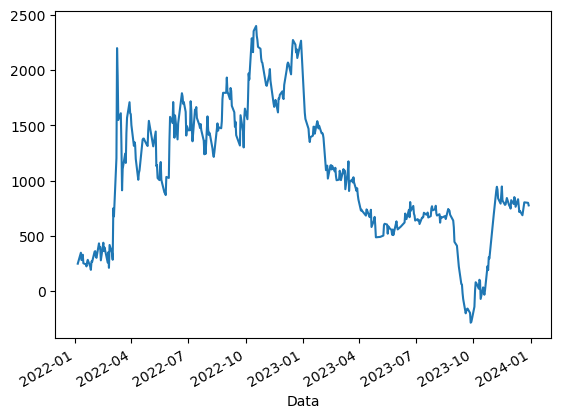

In [32]:
# Obliczanie reszt
brent_PLN_2022['Residuals'] = brent_PLN_2022['Eurodiesel'] - brent_PLN_2022['Predicted Eurodiesel Price']
brent_PLN_2022['Residuals'].plot()

In [34]:
residuals_std_dev = np.std(brent_PLN_2022['Residuals'])
mean = np.mean(brent_PLN_2022['Residuals'])
brent_PLN_2022['Anomaly'] = brent_PLN_2022['Residuals'].apply(
    lambda x: 'Anomaly' if np.abs(x - mean) > 2 * residuals_std_dev else 'Normal')

C:\Users\MariuszKamiński\AppData\Local\Temp\ipykernel_16408\712034061.py:36: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 0.85, 1])


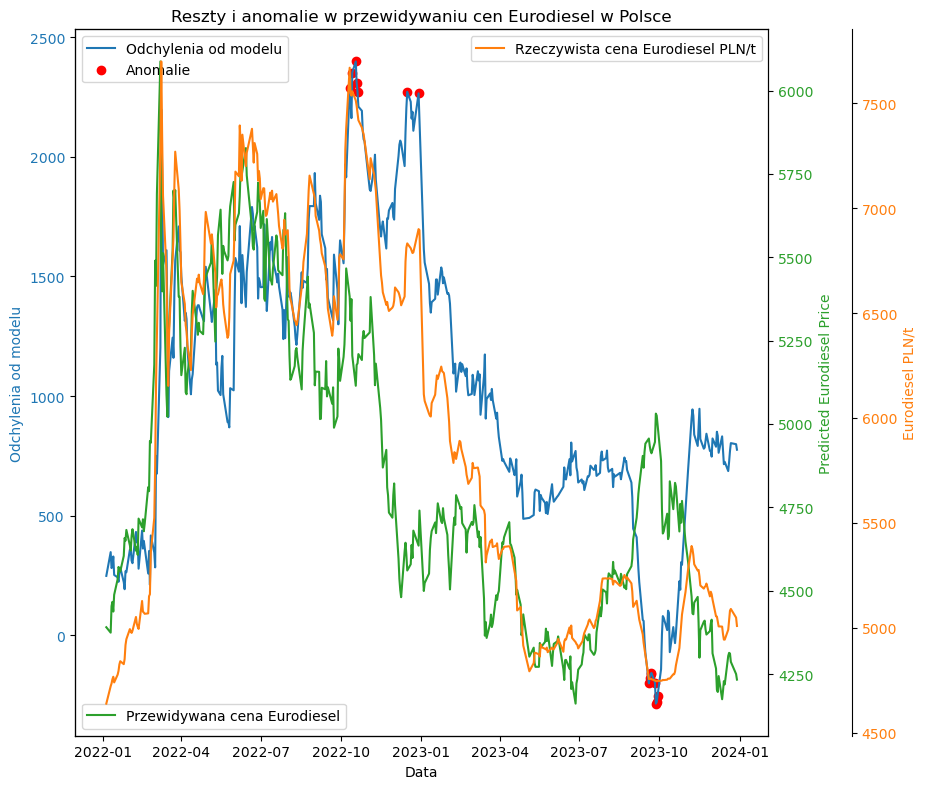

In [48]:
import matplotlib.pyplot as plt

anomalies = brent_PLN_2022[brent_PLN_2022['Anomaly'] == 'Anomaly']
fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('Data')
ax1.set_ylabel('Odchylenia od modelu', color=color)
ax1.plot(brent_PLN_2022.index, brent_PLN_2022['Residuals'], color=color, label = 'Odchylenia od modelu')
ax1.tick_params(axis='y', labelcolor=color)

# Dodanie scatter plot dla anomalii
ax1.scatter(anomalies.index, anomalies['Residuals'], color='red', label='Anomalie')

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Predicted Eurodiesel Price', color=color)
ax2.plot(brent_PLN_2022.index, brent_PLN_2022['Predicted Eurodiesel Price'], color=color, label = 'Przewidywana cena Eurodiesel')
ax2.tick_params(axis='y', labelcolor=color)

# Utworzenie drugiego twin axis dla rzeczywistej ceny Eurodiesel
ax3 = ax1.twinx()
color = 'tab:orange'
# Pozycja dla dodatkowej osi Y (prawej strony)
ax3.spines['right'].set_position(('outward', 60))      
ax3.set_ylabel('Eurodiesel PLN/t', color=color)
ax3.plot(brent_PLN_2022.index, brent_PLN_2022['Eurodiesel'], color=color, label = 'Rzeczywista cena Eurodiesel PLN/t')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Reszty i anomalie w przewidywaniu cen Eurodiesel w Polsce')
fig.tight_layout()  

ax1.legend(loc='upper left')  
ax2.legend(loc='lower left')  
ax3.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
fig.tight_layout(rect=[0, 0, 0.85, 1])

plt.legend()
plt.show()
